# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import re
import math
import spacy
import torch
import transformers
import matplotlib
import matplotlib.pyplot as plt
import joblib
from joblib import load
from joblib import dump


import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from IPython.display import display

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer

import sklearn.metrics as metrics
from sklearn.metrics  import f1_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

In [4]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
stop_words = set(stopwords.words('english'))

## Load Data

In [5]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

## EDA

In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [8]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


Let's check the number of movies and reviews over years.

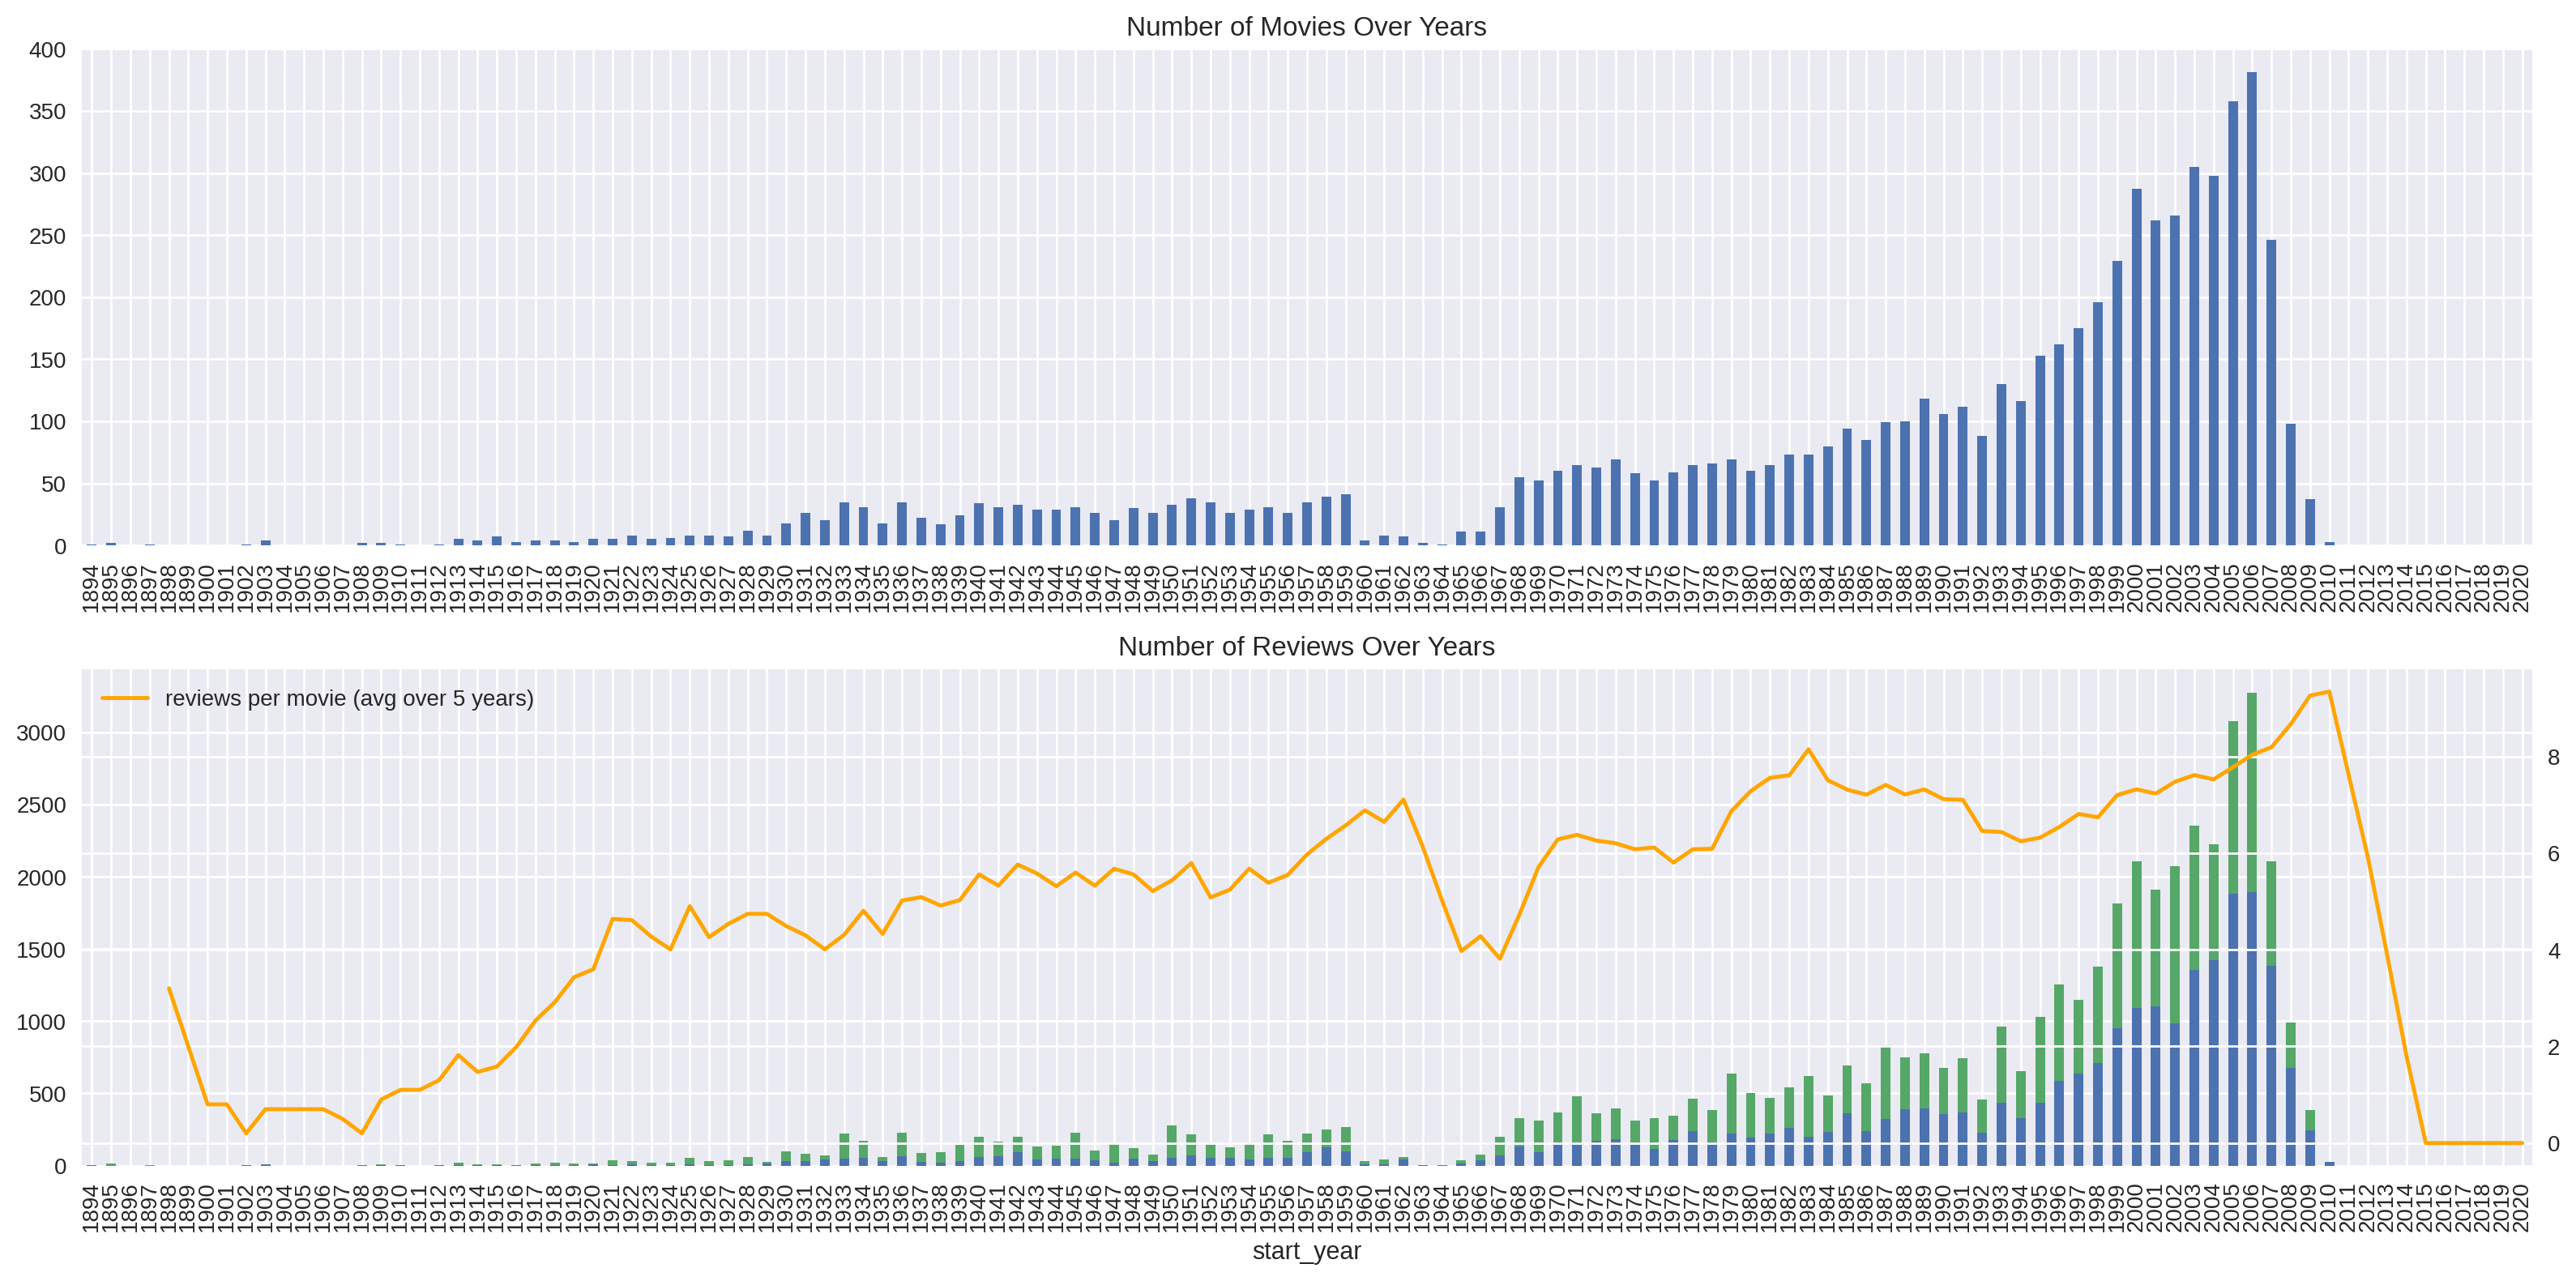

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

With the number of movies over the years, it seems clear that there's an upward trend of movies being produced over time (circa 1980 or 1985 and beyond); the highest peak is in 2006 with over 350+ film. Although the drastic drop off can be seen around the following year in 2007 with about 250 films, and dropping down rapidly under 50 films in 2009. As for the number of reviews, my biggest assumption is that the trend follows allong the movie releases. With the 2006's year their reviews easily skyrocketed beyound 3,000 and as for the following year, just a little bit over 2,000.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

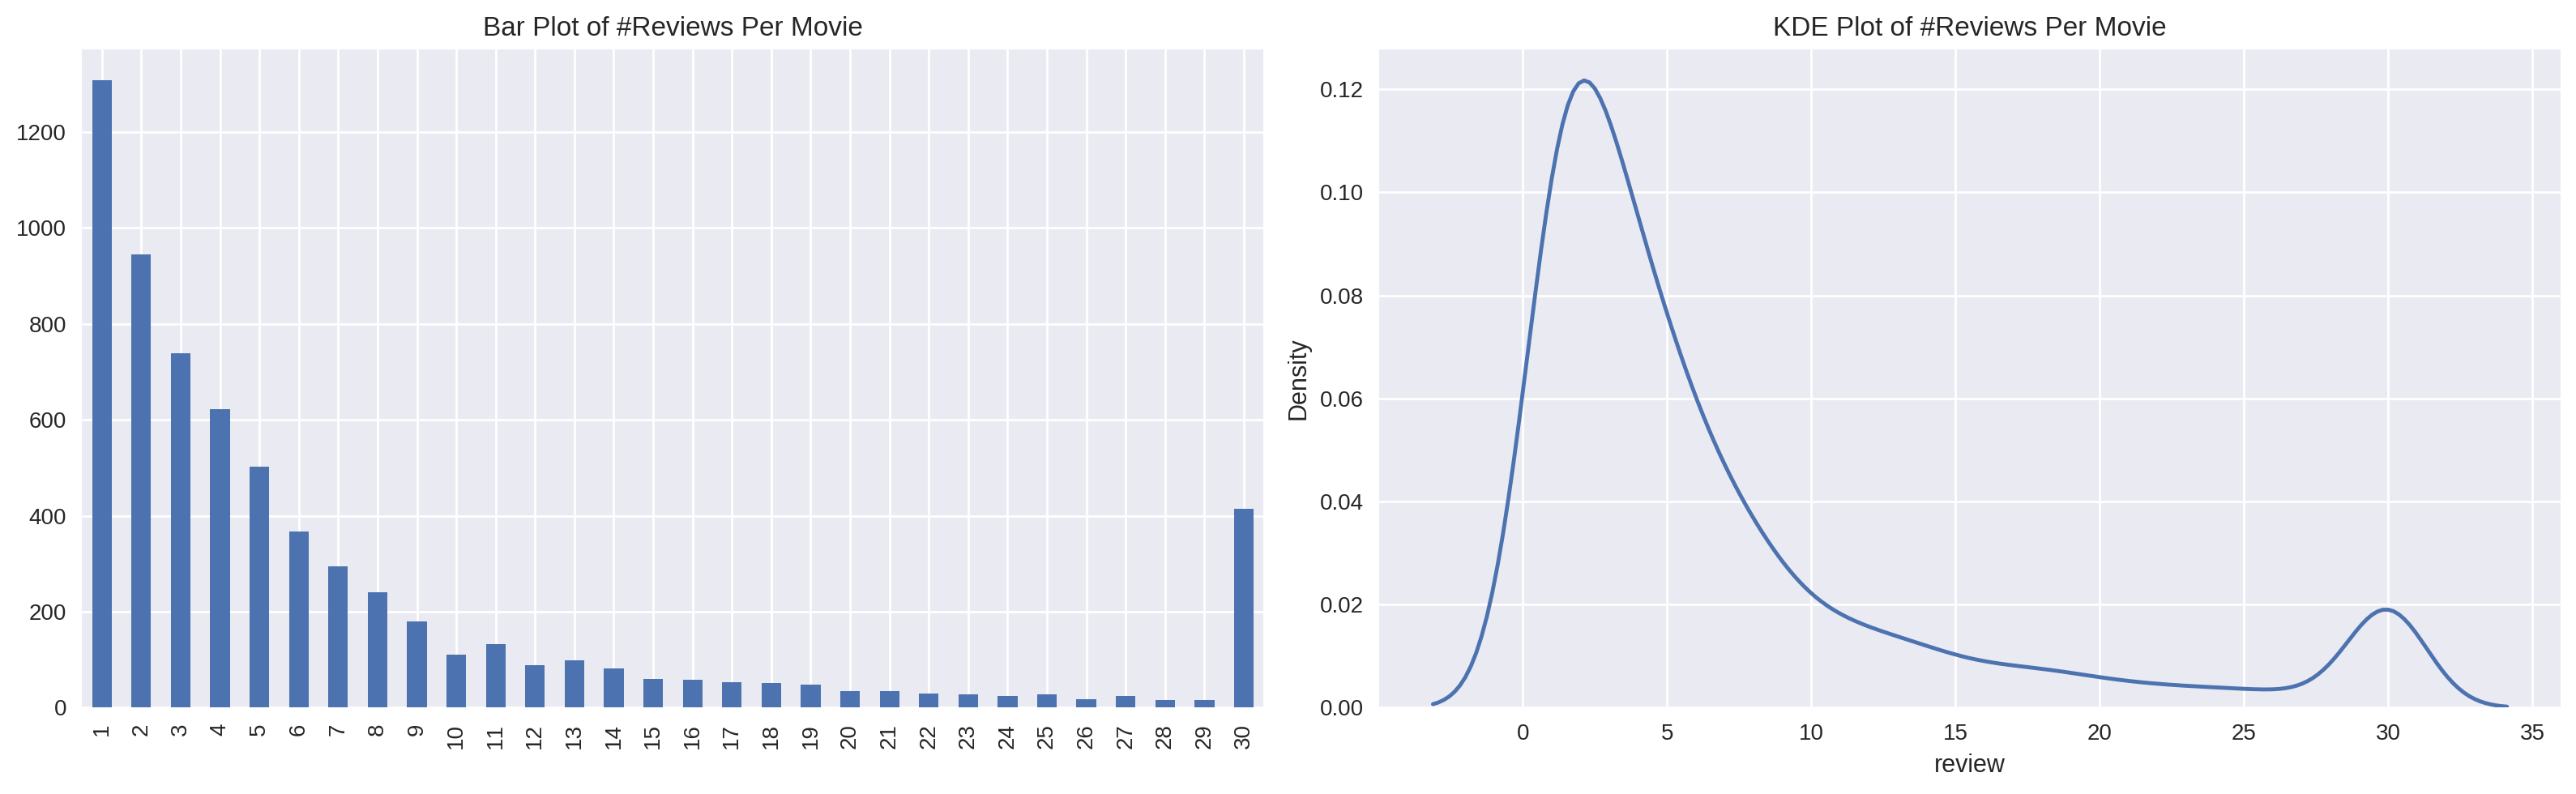

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

From what the Bar and KDE plot shows, there's a right-skewed distribution in reviews per movie. Thus indication that most movies have fewer reviews while there's a gradual drop but rolling wave of reviews per movies until it jumps up to very few movies with 30 reviews.

In [11]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

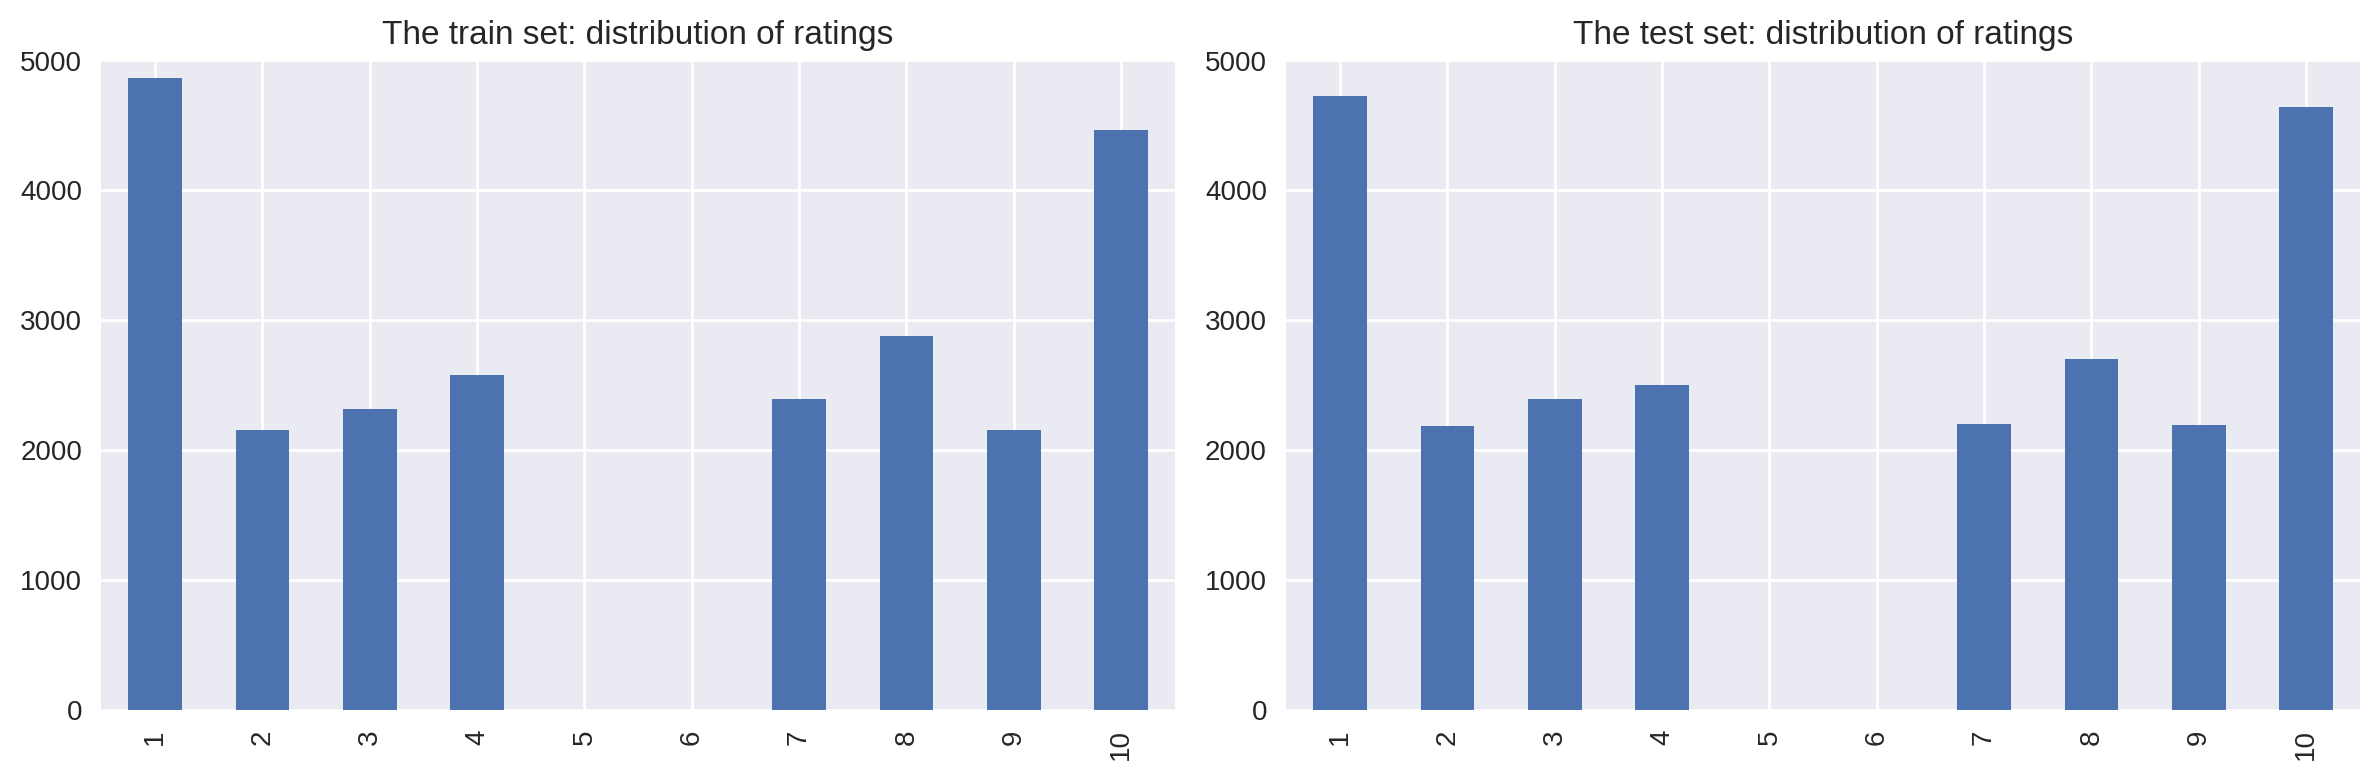

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

In [13]:
train_rating = df_reviews.query('ds_part == "train"')['rating'].value_counts().sum()
print(train_rating)
df_reviews.query('ds_part == "train"')['rating'].value_counts()

23796


1     4863
10    4462
8     2876
4     2577
7     2393
3     2317
2     2155
9     2153
Name: rating, dtype: int64

In [14]:
test_rating = df_reviews.query('ds_part == "test"')['rating'].value_counts().sum()
print(test_rating)
df_reviews.query('ds_part == "test"')['rating'].value_counts()

23535


1     4726
10    4642
8     2700
4     2501
3     2392
7     2200
9     2190
2     2184
Name: rating, dtype: int64

Initally at first glance, both distributions are also being measured on a scale between 1 to 10. I thought the training and testing distribution were questionably alike but they are just quite similar but I have a slight impression that there's a bias for most ratings to be either a 1 or 10 in both datasets and or most people are going to comment they really, really enjoyed the film with a solid 8 or 10, or really, really did not enjoy the film with a solid 1 or 4.

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


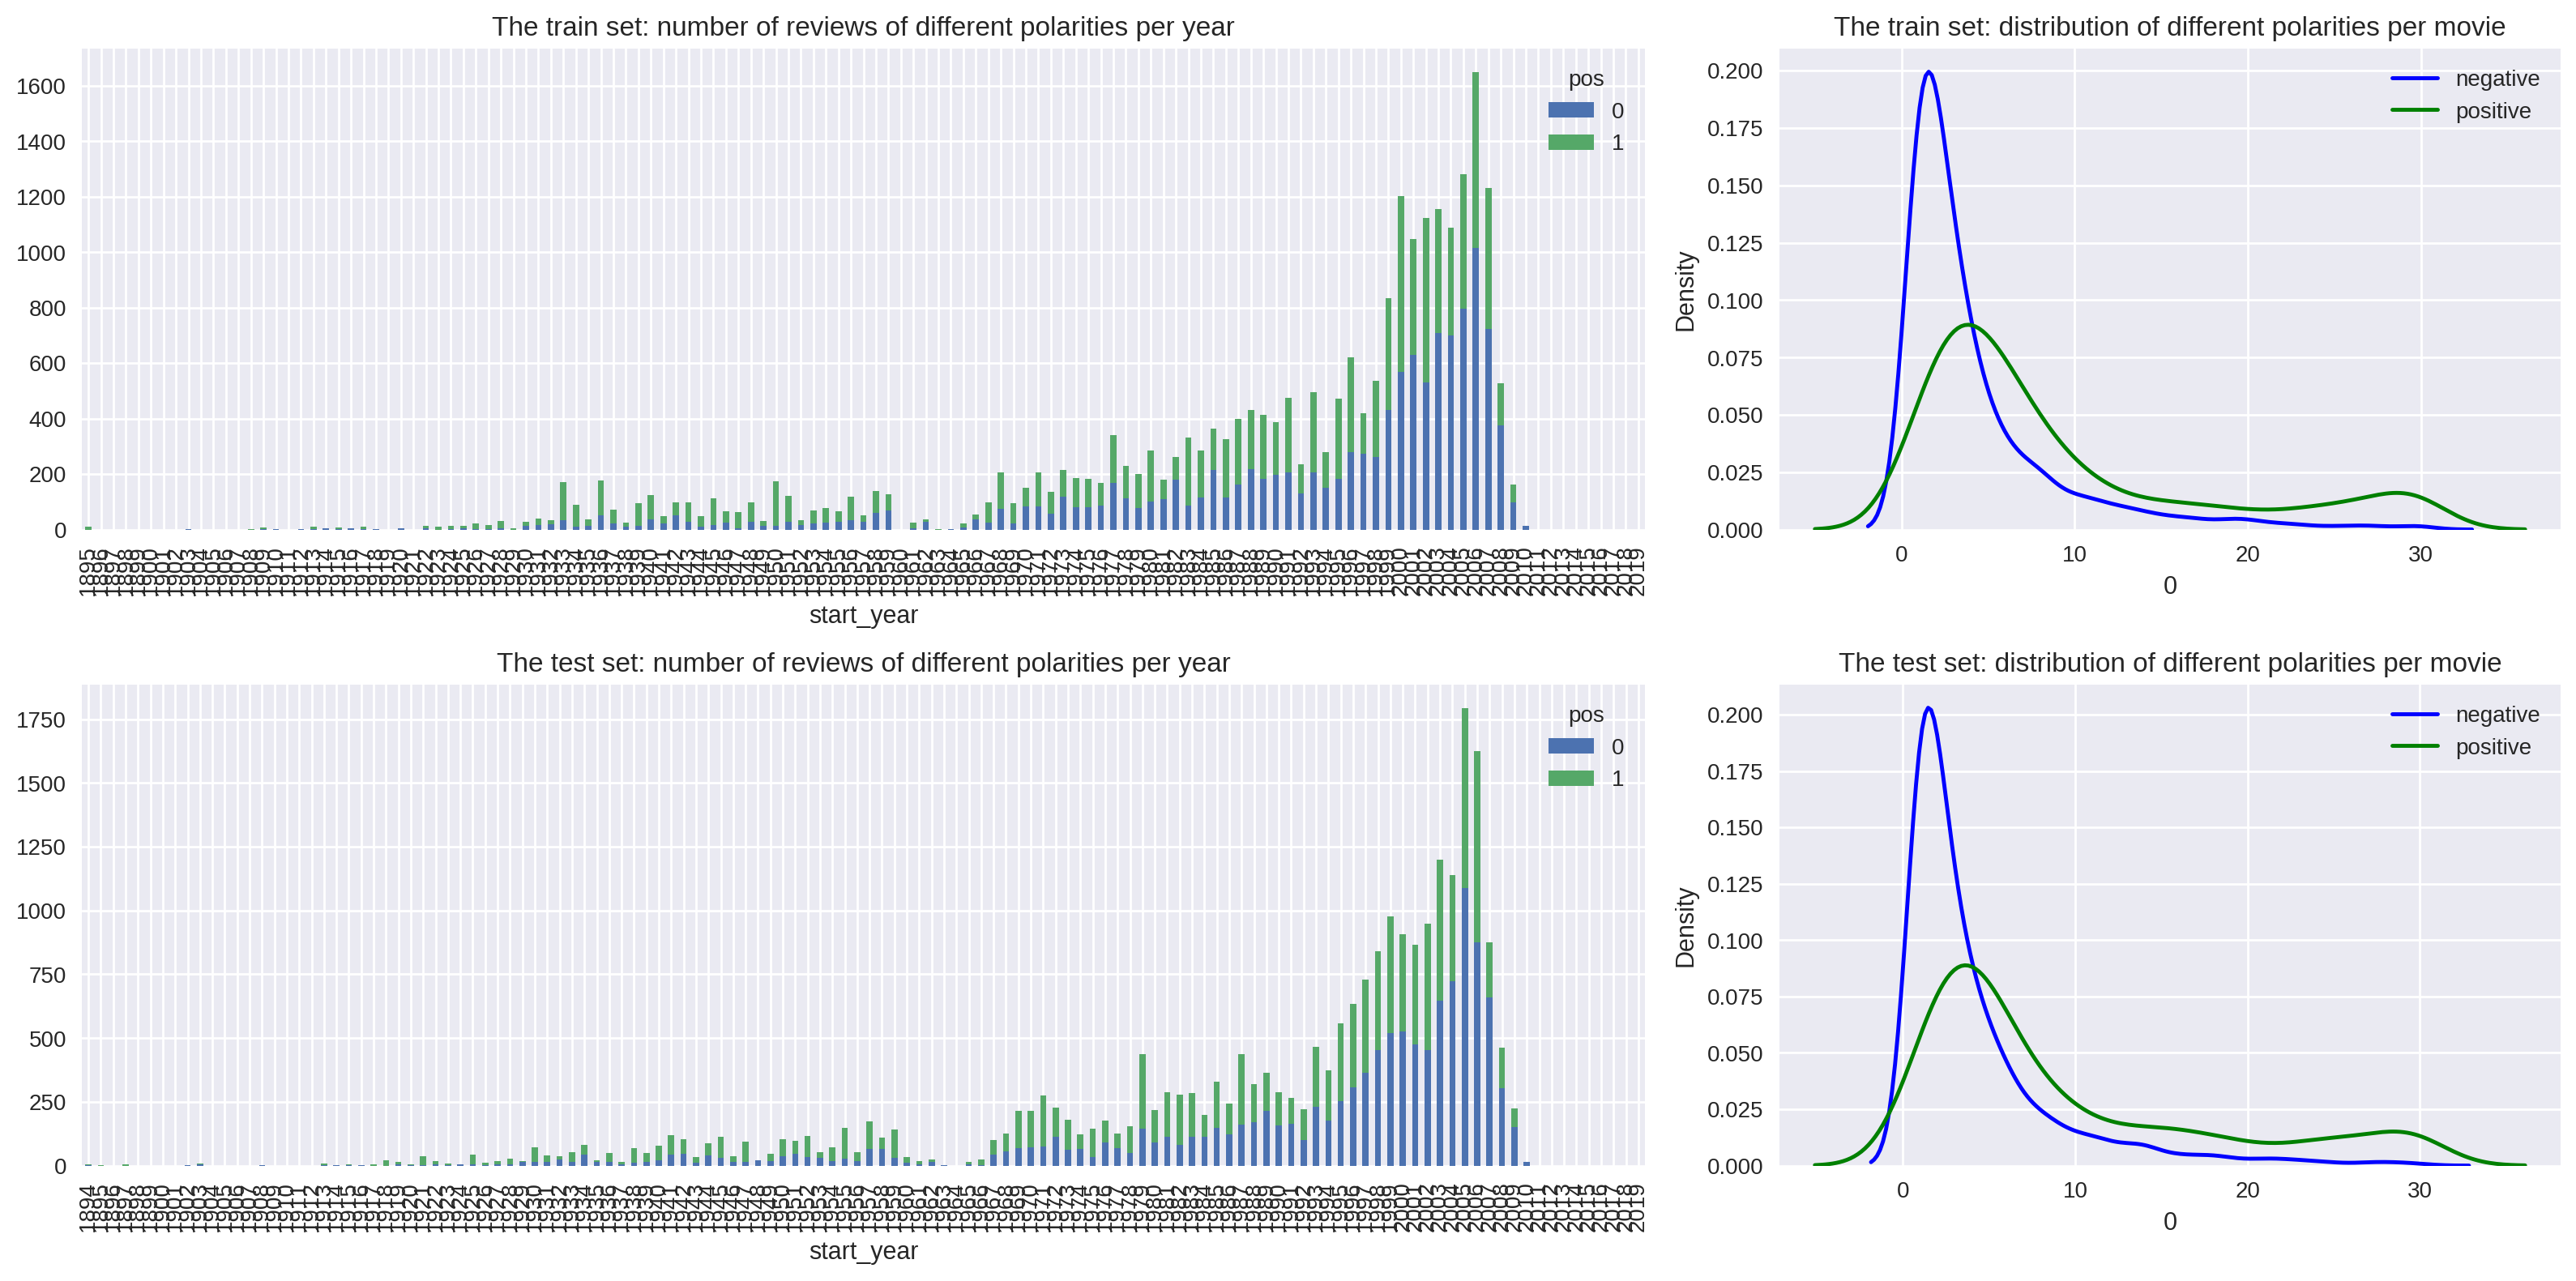

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

Well it seems to me, at first glance, that both the dataset still share similar distributions of both positive and negative reviews over time and per movie. But upon further analyzing, the positive reviews could indicate a class imbalance in its favor over the negative group as this is definitely seen a lot more clearly over the years in green on the left side of the image with the bar charts.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [16]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [17]:
def normalize_text(text, pattern=r'[\d\W]+'):
    text = text.lower() #lowercase text
    text = re.sub(pattern, " ", text) #replace digits & non-word characters with a space
    text = " ".join(text.split()) #drop extra space
    return text

df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text) #this is what you use within the models

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [18]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(f'Train features shape: {df_reviews_train.shape}')
print(f'Train target shape: {train_target.shape} \n')
print(f'Test features shape: {df_reviews_test.shape}')
print(f'Test target shape: {test_target.shape}')

Train features shape: (23796, 18)
Train target shape: (23796,) 

Test features shape: (23535, 18)
Test target shape: (23535,)


## Working with models

### Model 0 - Constant

In [19]:
vectorizer = TfidfVectorizer()
dm_train_ft = vectorizer.fit_transform(df_reviews_train['review_norm'])
dm_test_ft = vectorizer.transform(df_reviews_test['review_norm'])

dm_train_trgt = train_target.copy()
dm_test_trgt = test_target.copy()

In [20]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(dm_train_ft, dm_train_trgt)

DummyClassifier(strategy='stratified')

          train  test
Accuracy    0.5  0.51
F1          0.5  0.50
APS         0.5  0.50
ROC AUC     0.5  0.50


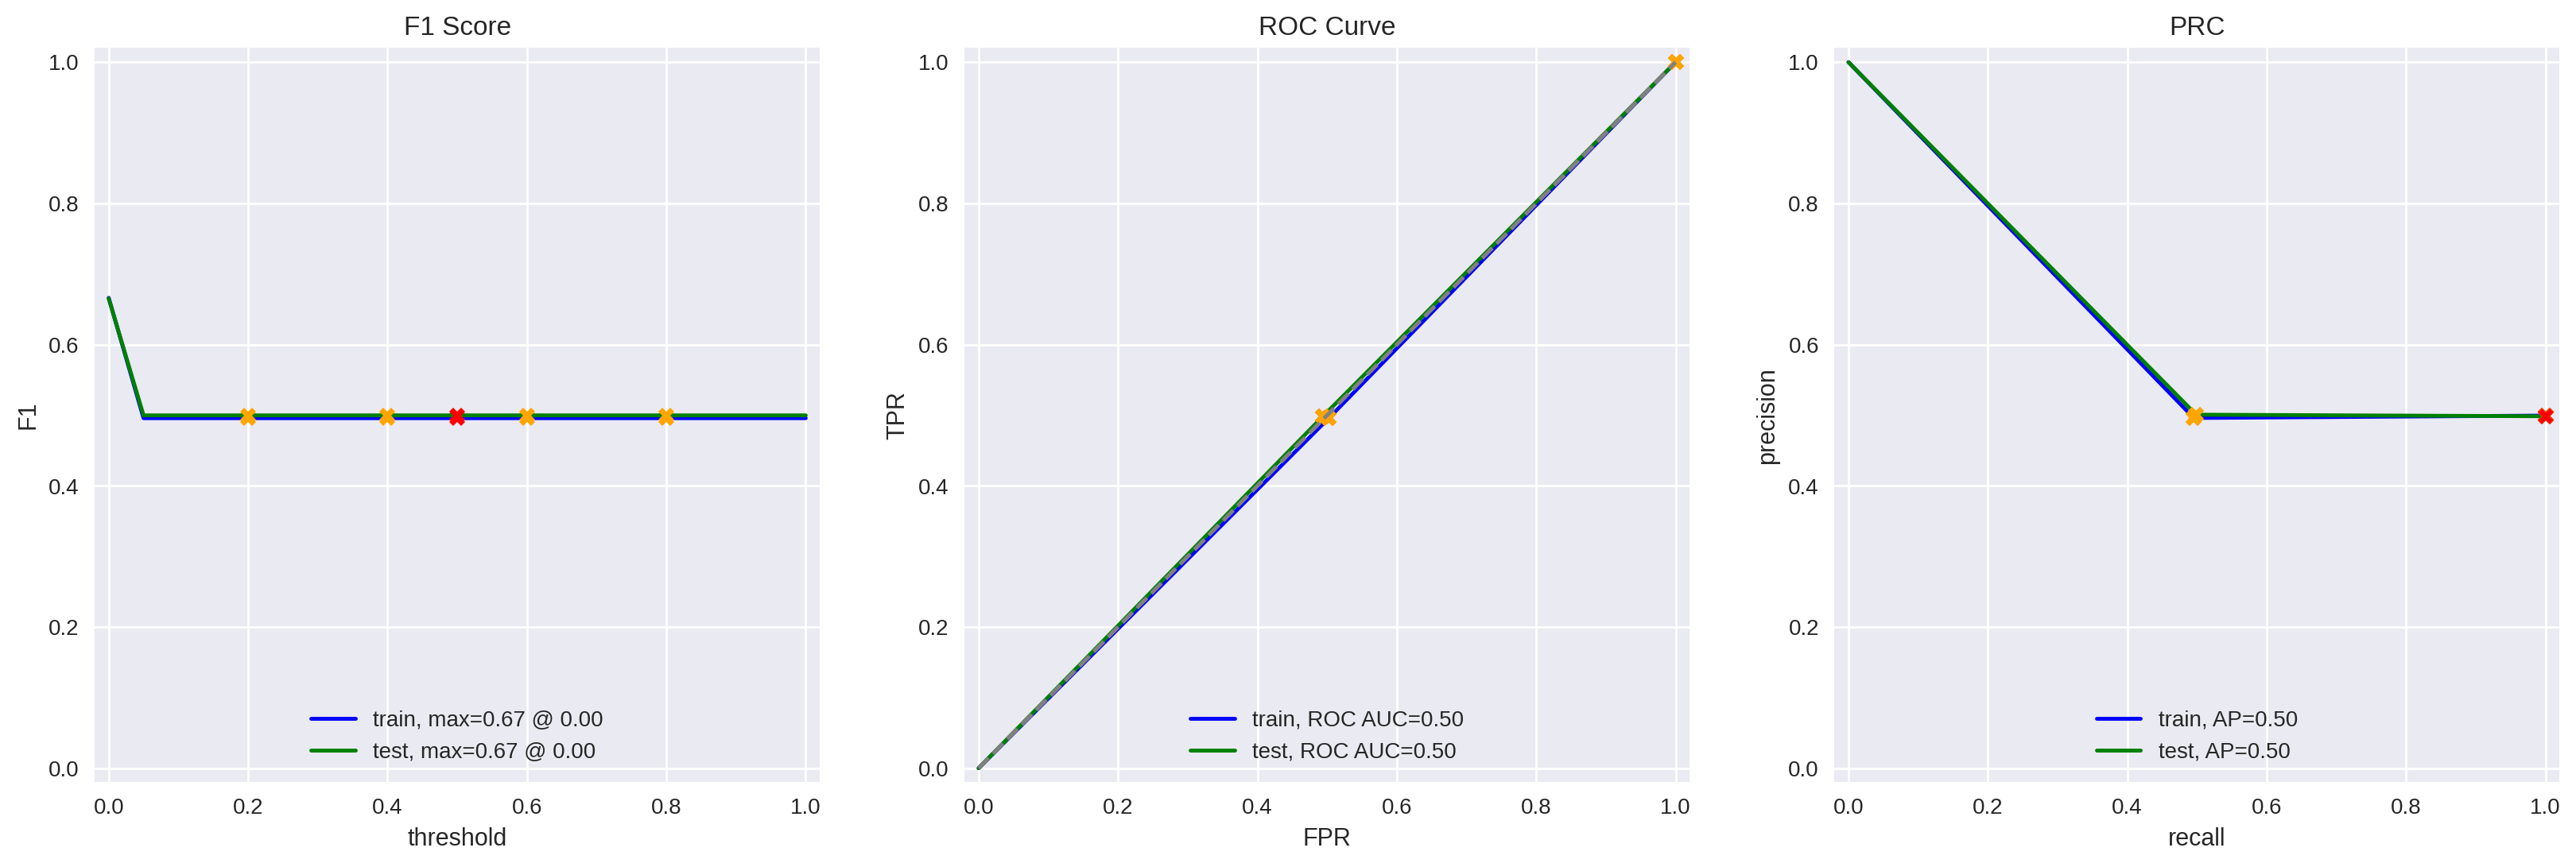

In [21]:
evaluate_model(dummy_clf, dm_train_ft, dm_train_trgt, dm_test_ft, dm_test_trgt)

### Model 1 - NLTK, TF-IDF and LR

In [22]:
lr_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words=stop_words)), ('model', LogisticRegression())])



lr_pipeline.fit(df_reviews_train['review_norm'], train_target)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('model', LogisticRegression())])

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


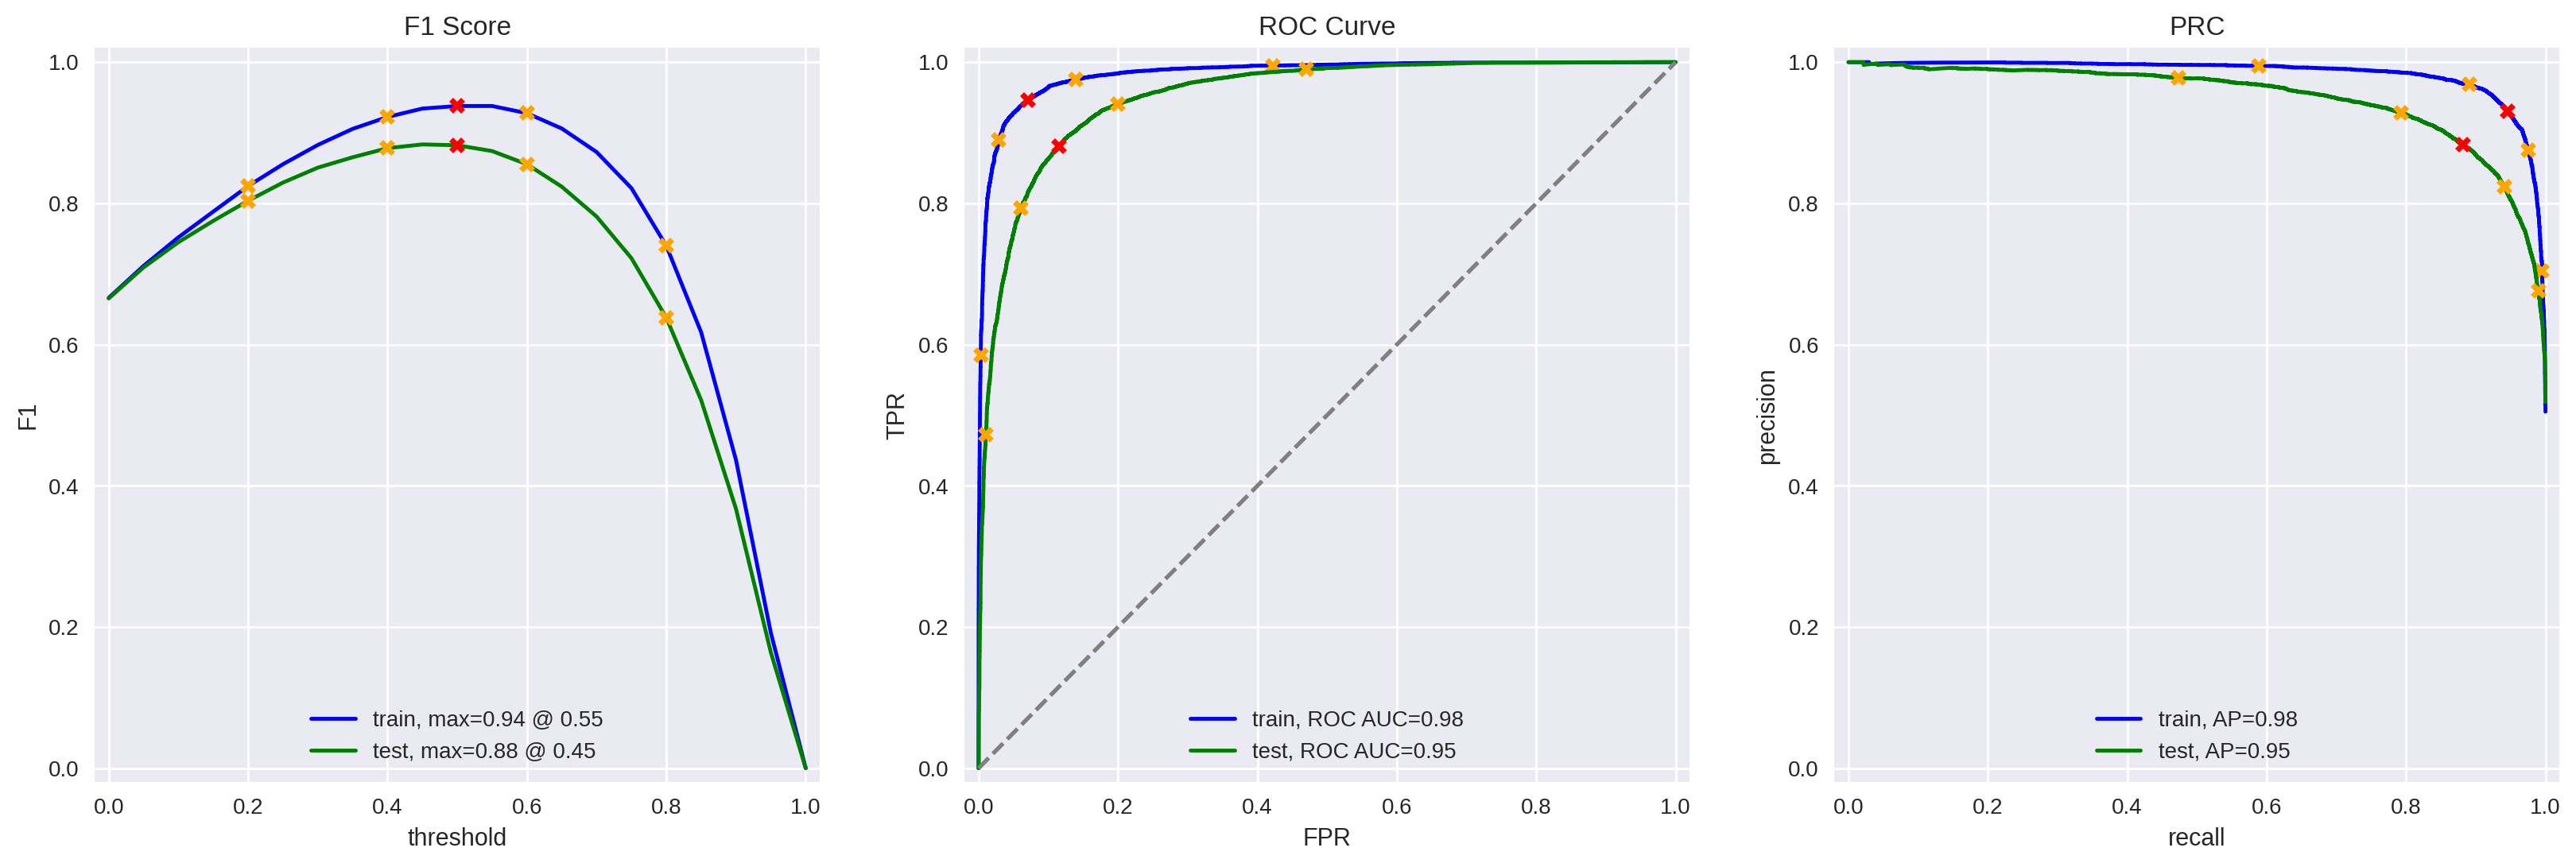

In [23]:
evaluate_model(lr_pipeline, df_reviews_train['review_norm'], train_target, df_reviews_test['review_norm'], test_target)

### Model 3 - spaCy, TF-IDF and LR

In [24]:
def text_preprocessing_3(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)

In [25]:
df_reviews_train['review_norm'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_norm'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)

In [26]:
lr_pipeline_spacy = Pipeline([('tfidf', TfidfVectorizer(stop_words=stop_words)), ('model', LogisticRegression())])
lr_pipeline_spacy.fit(df_reviews_train['review_norm'], train_target)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('model', LogisticRegression())])

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


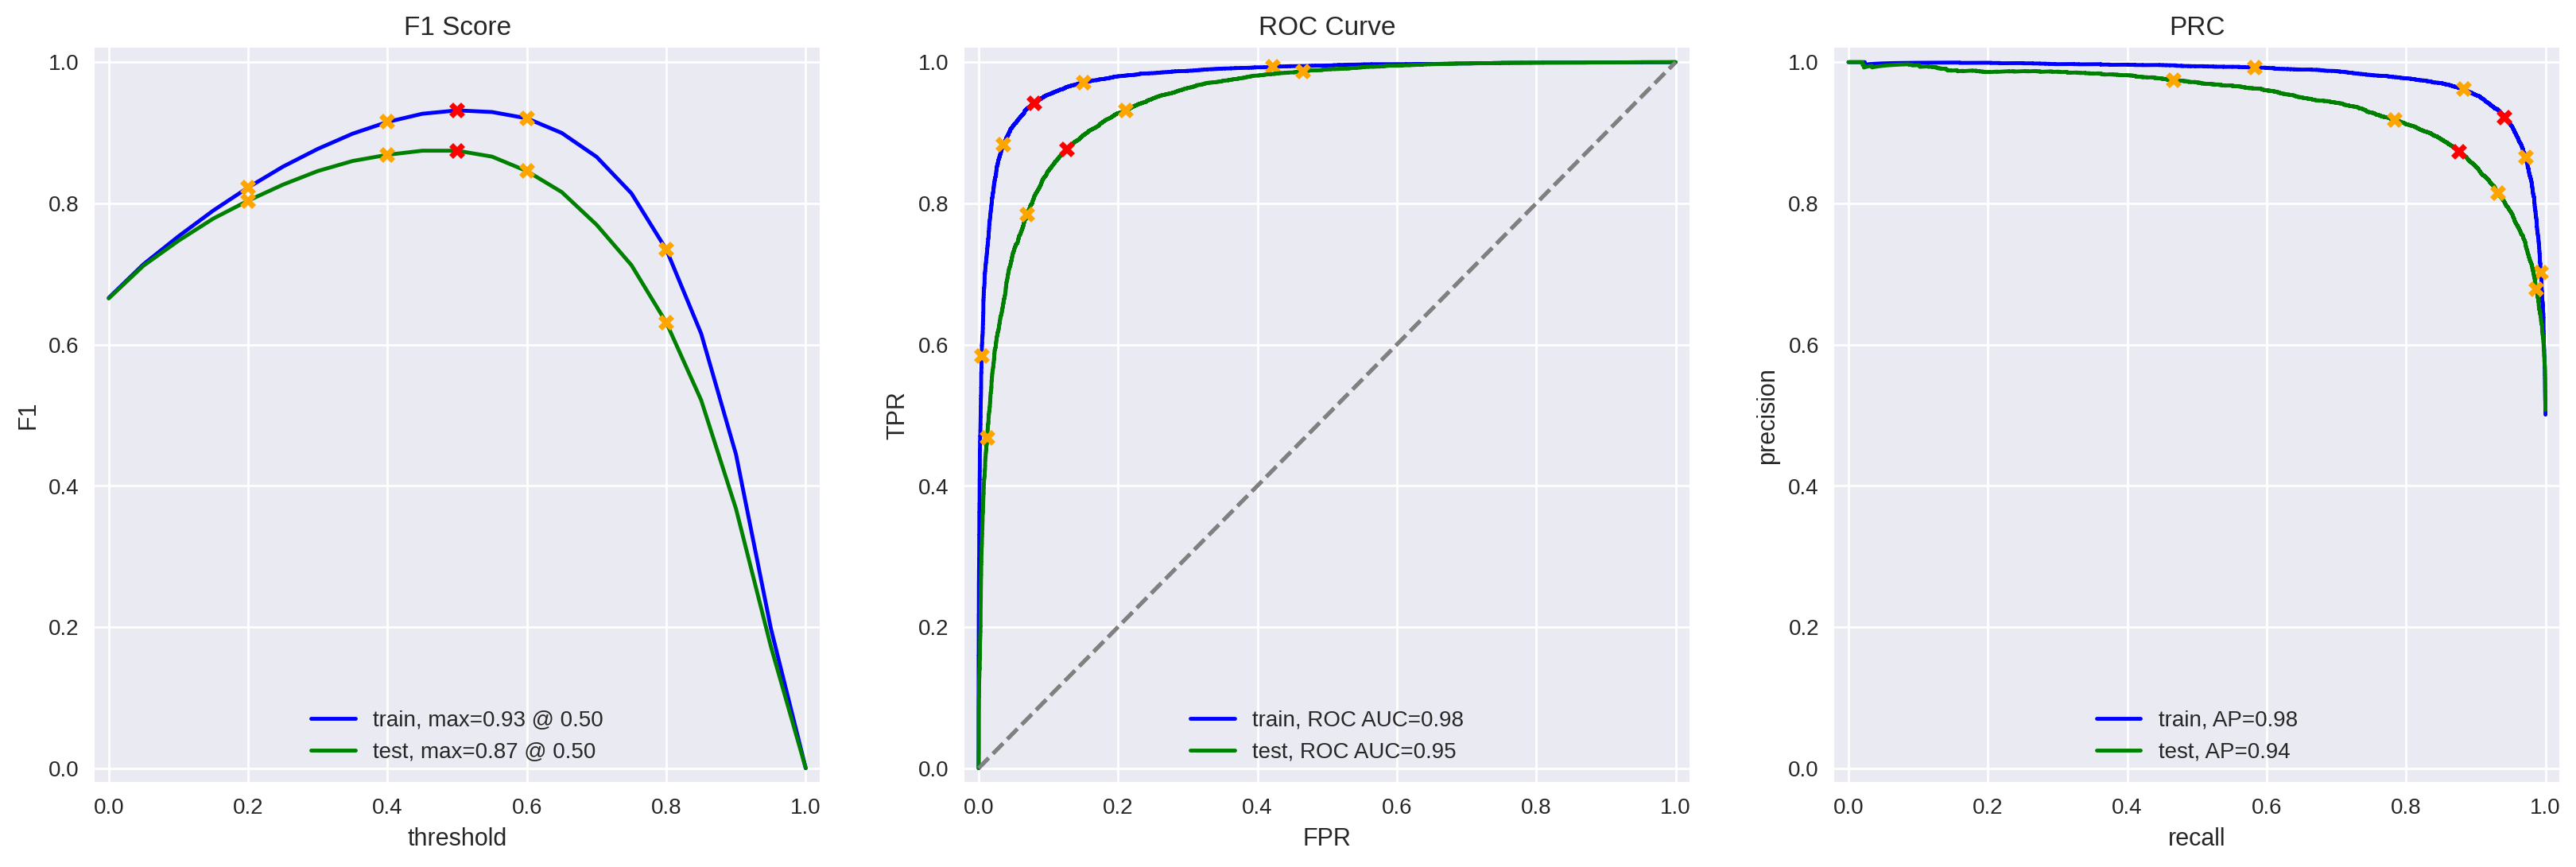

In [27]:
evaluate_model(lr_pipeline_spacy, df_reviews_train['review_norm'], train_target, df_reviews_test['review_norm'], test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [28]:
pipeline_4 = Pipeline([('tfidf', TfidfVectorizer(stop_words=stop_words)), ('model', LGBMClassifier())])
pipeline_4.fit(df_reviews_train['review_norm'], train_target)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('model', LGBMClassifier())])

          train  test
Accuracy   0.91  0.85
F1         0.91  0.85
APS        0.97  0.93
ROC AUC    0.97  0.93


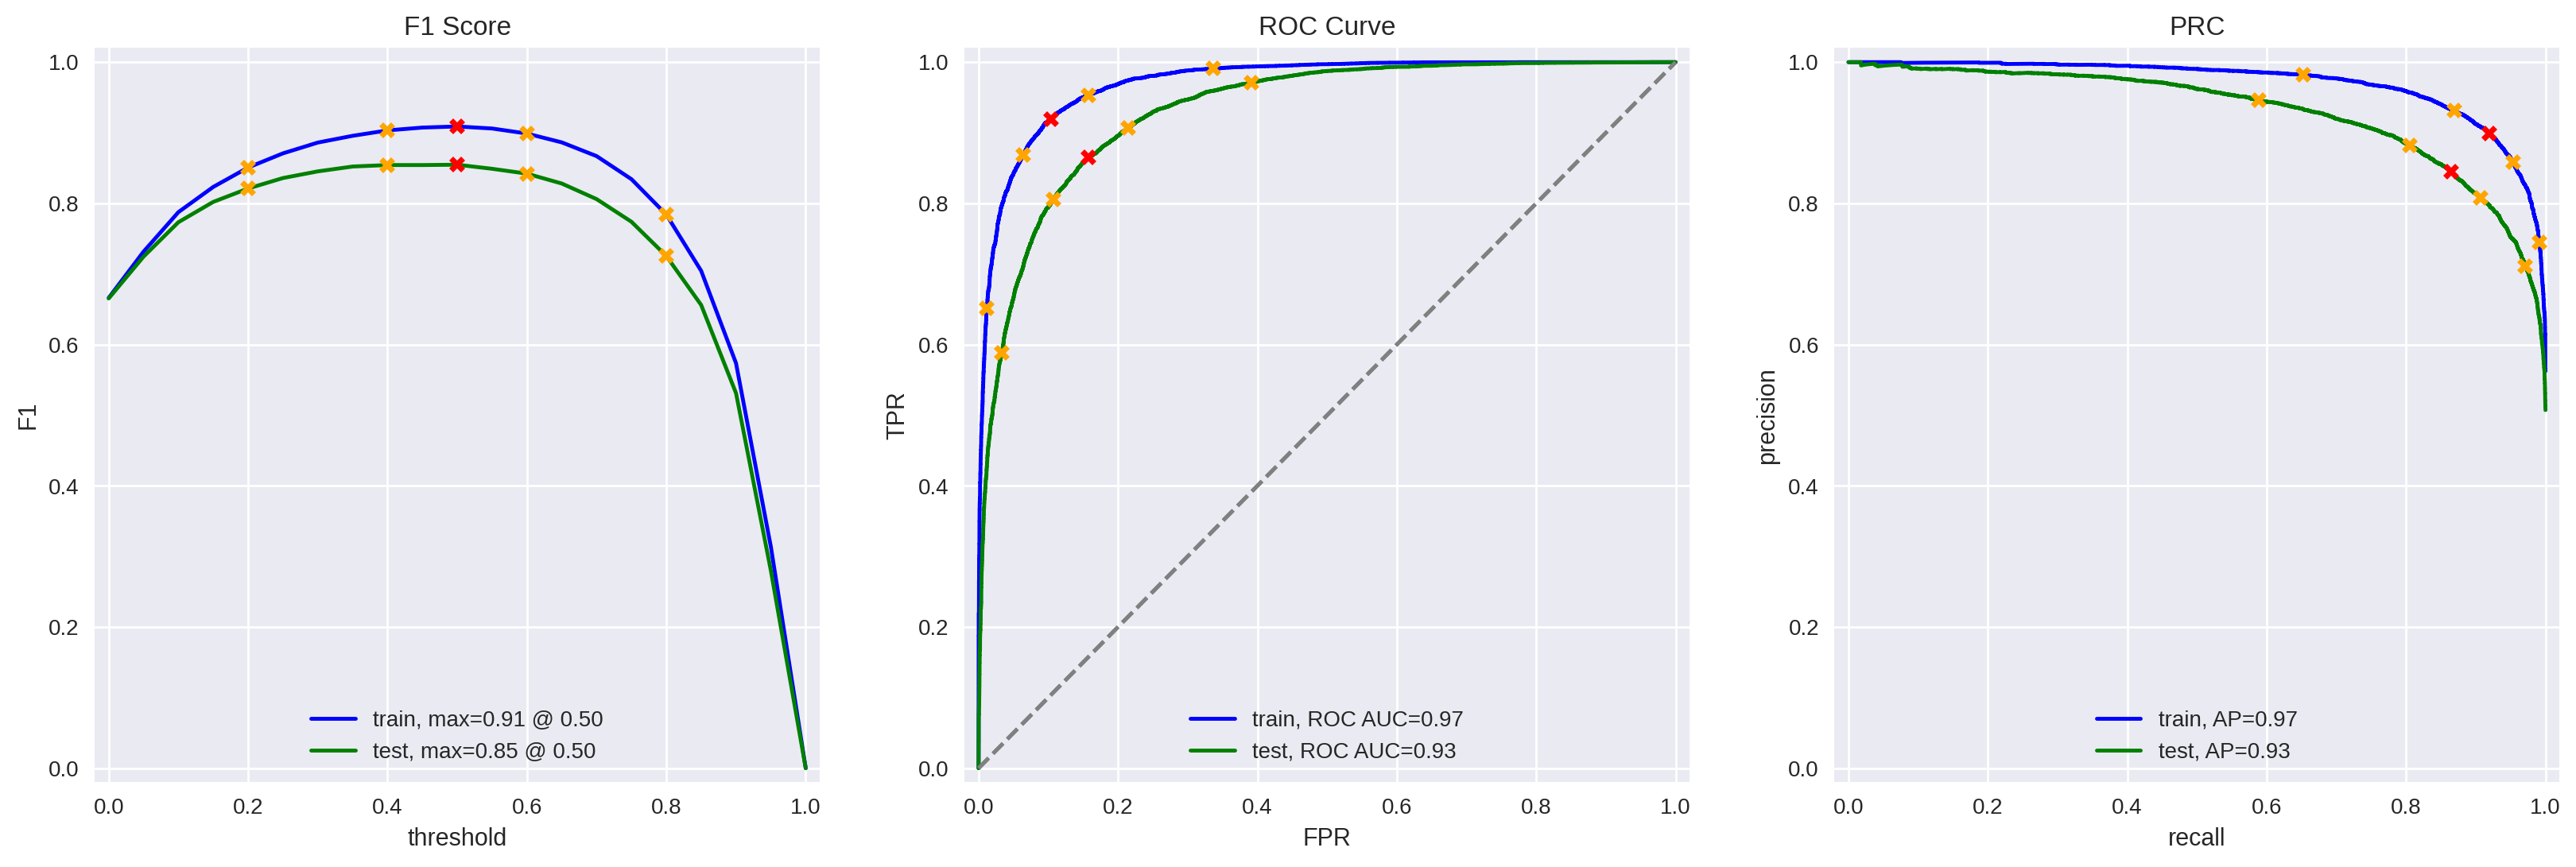

In [29]:
evaluate_model(pipeline_4, df_reviews_train['review_norm'], train_target, df_reviews_test['review_norm'], test_target)

### Model 9 - NLTK, TF-IDF and XGBoost (in replacement of Bert)

In [30]:
pipeline_9 = Pipeline([('tfidf', TfidfVectorizer(stop_words=stop_words)), ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))])
pipeline_9.fit(df_reviews_train['review_norm'], train_target)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, co...
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_wei

          train  test
Accuracy   0.94  0.85
F1         0.94  0.85
APS        0.99  0.92
ROC AUC    0.99  0.93


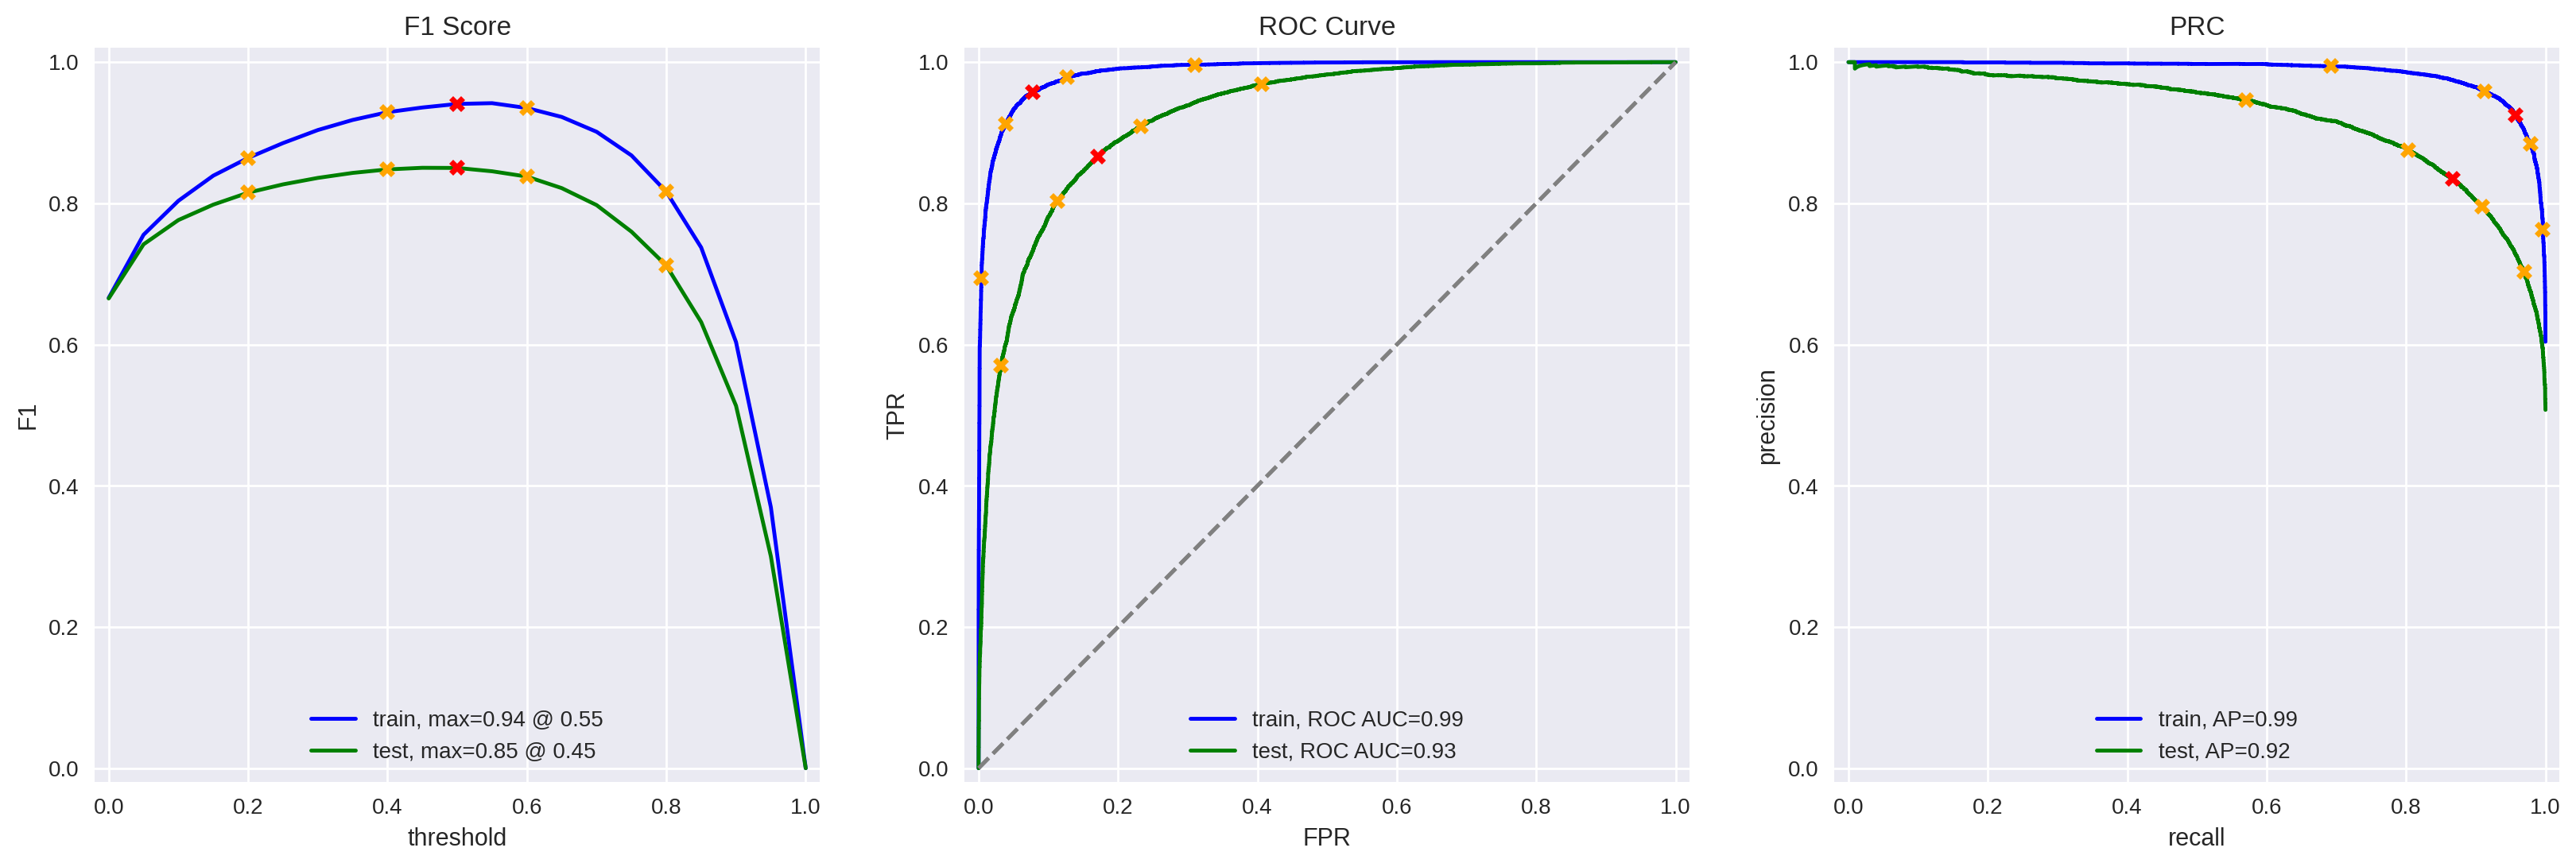

In [31]:
evaluate_model(pipeline_9, df_reviews_train['review_norm'], train_target, 
               df_reviews_test['review_norm'], test_target)

After going back to fine tune all of the models, all models performed well with at least a 85% F1-Score; although, both Logisitic Regression models did better than the gradient-based models with an 87% (spaCy LR) & 88% (NLTK LR) by a 2-3% margin. But overall, all models hit the F1-Score threshold as they were capable of understanding the sentiment within the movie reviews.

## My Reviews

In [32]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'This was so boring, I would have rather took my money elsewhere',
    'The actors and actresses down to the cinematgraphy was an utter masterpiece - a job well done.',
    'For anyone that is probably hating, does not get why this did so well and especially great overseas, they are not real movie buffs if they hated it.',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

In [33]:
def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)

In [34]:
my_reviews['review_norm'] = my_reviews['review'].apply(preprocess_text)
my_reviews.head(5)

,review,review_norm
0,"I did not simply like it, not my kind of movie.",simply like kind movie
1,"Well, I was bored and felt asleep in the middl...",well bored felt asleep middle movie
2,I was really fascinated with the movie,really fascinated movie
3,"This was so boring, I would have rather took m...",boring would rather took money elsewhere
4,The actors and actresses down to the cinematgr...,actors actresses cinematgraphy utter masterpie...


### Model 0 - Constant

In [35]:
texts = my_reviews['review_norm']
my_reviews_pred_prob = dummy_clf.predict_proba(texts)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

1.00:  simply like kind movie
0.00:  well bored felt asleep middle movie
1.00:  really fascinated movie
1.00:  boring would rather took money elsewhere
0.00:  actors actresses cinematgraphy utter masterpiece job well done
1.00:  anyone probably hating get well especially great overseas real movie buffs hated
0.00:  even actors looked really old disinterested got paid movie soulless cash grab
1.00:  expect reboot good writers really cared source material
0.00:  movie upsides downsides feel like overall decent flick could see going see
1.00:  rotten attempt comedy single joke lands everyone acts annoying loud even kids wo like
0.00:  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


### Model 1 - NLTK, TF-IDF and LR

In [36]:
texts = my_reviews['review_norm']
my_reviews_pred_prob = lr_pipeline.predict_proba(texts)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  simply like kind movie
0.16:  well bored felt asleep middle movie
0.54:  really fascinated movie
0.01:  boring would rather took money elsewhere
0.88:  actors actresses cinematgraphy utter masterpiece job well done
0.87:  anyone probably hating get well especially great overseas real movie buffs hated
0.11:  even actors looked really old disinterested got paid movie soulless cash grab
0.31:  expect reboot good writers really cared source material
0.47:  movie upsides downsides feel like overall decent flick could see going see
0.06:  rotten attempt comedy single joke lands everyone acts annoying loud even kids wo like
0.82:  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


### Model 3 - spaCy, TF-IDF and LR

In [37]:
texts = my_reviews['review_norm']
my_reviews_pred_prob = lr_pipeline_spacy.predict_proba(texts)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  simply like kind movie
0.05:  well bored felt asleep middle movie
0.49:  really fascinated movie
0.06:  boring would rather took money elsewhere
0.63:  actors actresses cinematgraphy utter masterpiece job well done
0.72:  anyone probably hating get well especially great overseas real movie buffs hated
0.43:  even actors looked really old disinterested got paid movie soulless cash grab
0.44:  expect reboot good writers really cared source material
0.62:  movie upsides downsides feel like overall decent flick could see going see
0.12:  rotten attempt comedy single joke lands everyone acts annoying loud even kids wo like
0.95:  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [38]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = pipeline_4.predict_proba(texts)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.53:  simply like kind movie
0.19:  well bored felt asleep middle movie
0.56:  really fascinated movie
0.16:  boring would rather took money elsewhere
0.63:  actors actresses cinematgraphy utter masterpiece job well done
0.84:  anyone probably hating get well especially great overseas real movie buffs hated
0.56:  even actors looked really old disinterested got paid movie soulless cash grab
0.71:  expect reboot good writers really cared source material
0.62:  movie upsides downsides feel like overall decent flick could see going see
0.24:  rotten attempt comedy single joke lands everyone acts annoying loud even kids wo like
0.83:  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


### Model 9  - NLTK, TF-IDF and XGBoost (in replacement of Bert)

In [39]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = pipeline_9.predict_proba(texts)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.54:  simply like kind movie
0.28:  well bored felt asleep middle movie
0.57:  really fascinated movie
0.19:  boring would rather took money elsewhere
0.69:  actors actresses cinematgraphy utter masterpiece job well done
0.85:  anyone probably hating get well especially great overseas real movie buffs hated
0.57:  even actors looked really old disinterested got paid movie soulless cash grab
0.64:  expect reboot good writers really cared source material
0.63:  movie upsides downsides feel like overall decent flick could see going see
0.38:  rotten attempt comedy single joke lands everyone acts annoying loud even kids wo like
0.80:  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


## Conclusions

After revisiting each model and making the appropriate revisisons, I am now able to see how each model's performance actually analyzed each movie review and gave a rated sentiment - especially since each model has surpassed the F1-Score 85% threshold outside of the Dummy model. We can clearly see knowing that the Dummy model serves as a baseline model to give us an idea how the other models should clearly outperform and analyze a sentiment a whole lot better than dummy would.

And so for example,

* For a positive review: **really fascinated movie**
* For a negative review: **boring would rather took money elsewhere**
* LR 1 Model = Model 1
* LR 3 Model = Model 3




| Review Type  | DM    | LR1   | LR3   | LGBM   | XGB
|:-------------|:-----------|:------|:------|:------|:------|
| Positive Review  | 0.00       | 0.54   | 0.49     | 0.56     | 0.57     |
| Negative Review  | 1.00    | 0.01   | 0.06     | 0.16     | 0.19     |



We can see how the XGB Model had the highest rating for the positive review; meanwhile Model 1: Logisitic Regression had the lowest rating for the negative review - despite both models utilizing the NLTK library. When compare to the Dummy model's performance I would say the sentiment analysis, across all models (outside of the dummy one) is quite reasonable given the length of the review and the value some words had over others in order to really pick up on whether to classify the review as a negative or positive. 